# Data cleaning and preprocessing

In [35]:
### Inputs

import pandas as pd
import numpy as np
import seaborn as sns
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
### Following dfs are used for content-based algorithm

movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")
keywords = pd.read_csv("keywords.csv")

In [3]:
### Examine the datasets

print("Movies dataset:")
# print(movies.head())
print(movies.info())

print("\nCredits dataset:")
# print(credits.head())
print(credits.info())

print("\nKeywords dataset:")
# print(keywords.head())
print(keywords.info())

Movies dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  statu

In [4]:
### Handle the missing values
## Only released movies are considered (not rumored, post-production)

movies.fillna("", inplace=True)
movies = movies[movies["status"]=="Released"]
movies = movies.drop(columns=["homepage", "overview", "tagline", "status"])


credits.fillna("", inplace=True)
keywords.fillna("", inplace=True)

# Dataset merging & final cleanup

In [5]:
### Function to get names from dicts of ids and names (applies to many columns in our data)
    # change 'name' to 'id' if 'id' is wanted instead

def extract_names(column_data):
    column_data = ast.literal_eval(column_data)
    names = [data['name'] for data in column_data]
    return names

In [6]:
### Prepares content_based_df
### Completes the following:
    # merges movies, credits, and keywords
    # cleans columns to get desired results by renaming columns and using extract_names function

content_based_df = movies.merge(credits, left_on="id", right_on="movie_id", suffixes=("_movies", "_credits"))
content_based_df.drop(columns=["title_credits", "movie_id"], inplace=True)

content_based_df = content_based_df.merge(keywords, on="id", suffixes=("", "_keywords"))
content_based_df.drop(columns=["keywords"], inplace=True)
content_based_df.rename(columns={"keywords_keywords": "keywords"}, inplace=True)

# Set manually
columns_to_clean = [
    'genres', 'production_companies', 'production_countries',
    'spoken_languages', 'cast', 'crew', 'keywords'
]

for column in columns_to_clean:
    content_based_df[column] = content_based_df[column].apply(extract_names)

content_based_df['release_date'] = pd.to_datetime(content_based_df['release_date'])

# Produces df with following columns (all 100% ready for next steps):
# ['budget', 'genres', 'id', 'original_language', 'original_title',
#       'popularity', 'production_companies', 'production_countries',
#       'release_date', 'revenue', 'runtime', 'spoken_languages',
#       'title_movies', 'vote_average', 'vote_count', 'cast', 'crew',
#       'keywords']

In [7]:
(content_based_df.head())

,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title_movies,vote_average,vote_count,cast,crew,keywords
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",19995,en,Avatar,150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Avatar,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B...","[culture clash, future, space war, space colon..."
1,300000000,"[Adventure, Fantasy, Action]",285,en,Pirates of the Caribbean: At World's End,139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Pirates of the Caribbean: At World's End,6.9,4500,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...","[ocean, drug abuse, exotic island, east india ..."
2,245000000,"[Action, Adventure, Crime]",206647,en,Spectre,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Spectre,6.3,4466,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...","[spy, based on novel, secret agent, sequel, mi..."
3,250000000,"[Action, Crime, Drama, Thriller]",49026,en,The Dark Knight Rises,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012-07-16,1084939099,165.0,[English],The Dark Knight Rises,7.6,9106,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Hans Zimmer, Charles Roven, Christopher Nolan...","[dc comics, crime fighter, terrorist, secret i..."
4,260000000,"[Action, Adventure, Science Fiction]",49529,en,John Carter,43.926995,[Walt Disney Pictures],[United States of America],2012-03-07,284139100,132.0,[English],John Carter,6.1,2124,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Andrew Stanton, John Lasseter...","[based on novel, mars, medallion, space travel..."


# Feature Engineering

### Categorical Feature Engineering (categorical variables handled)
***Variables Handled***:
- genres
- original_language
- production_companies
- production_countries
- spoken_languages

In [8]:
### Completes one-hot encoding on categorical variables

# Columns to be one-hot encoded are chosen manually
cat_features = ['genres', 'original_language', 'production_companies', 'production_countries', 'spoken_languages']
one_hot_encoded = pd.get_dummies(content_based_df[cat_features].applymap(lambda x: ' '.join(x)))

### Numerical Feature Engineering (numerical data)
***Variables Handled***
- budget
- popularity
- release_date
- revenue
- runtime
- vote_average
- vote_count

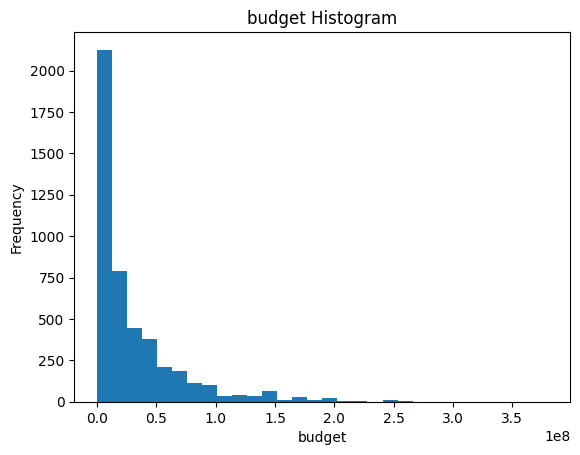

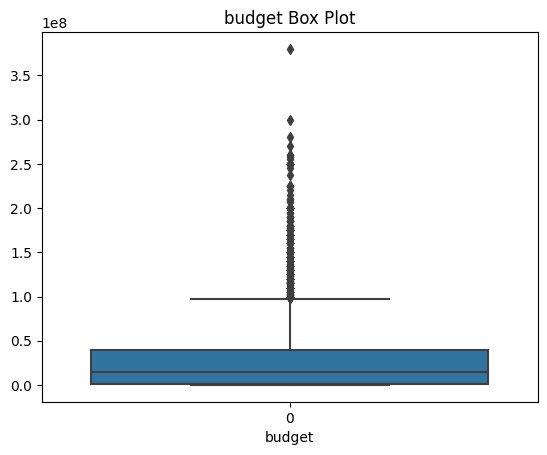

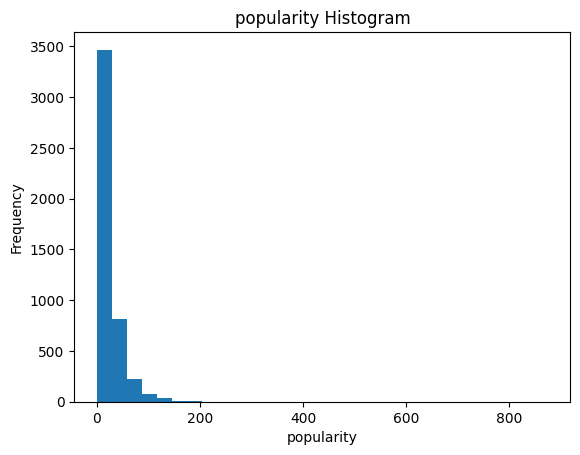

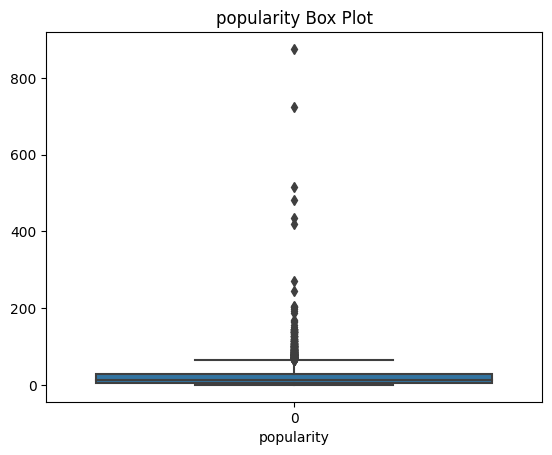

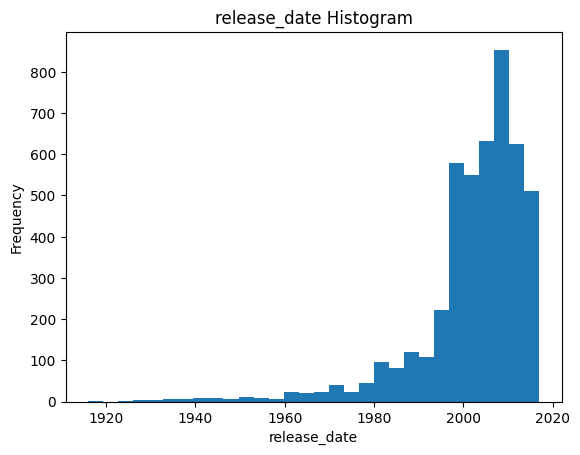

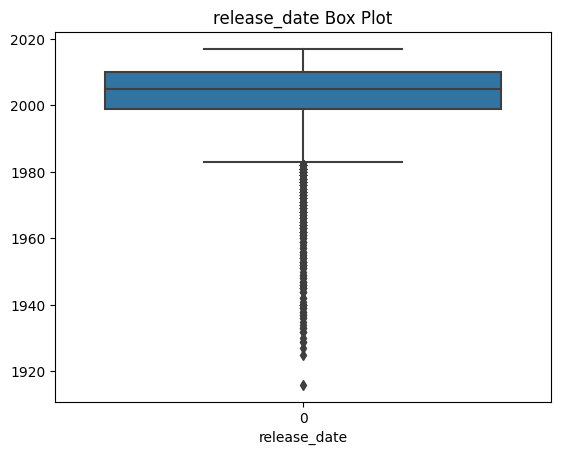

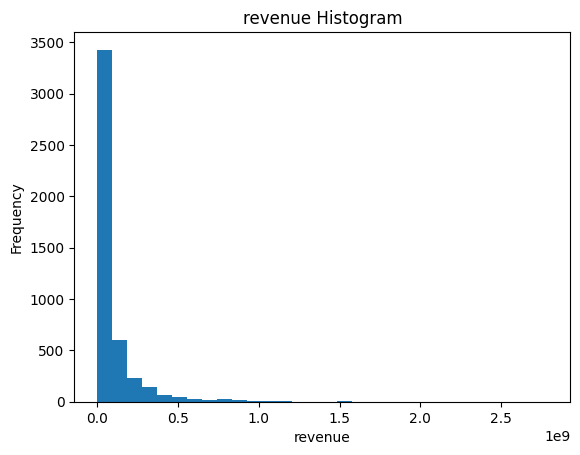

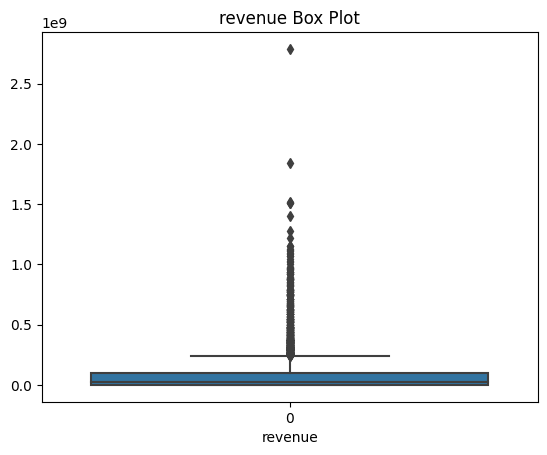

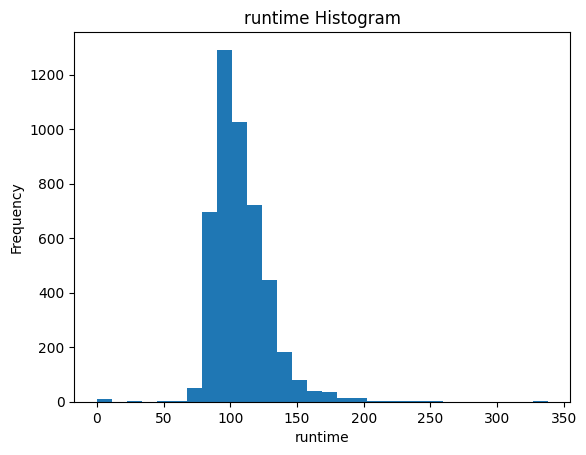

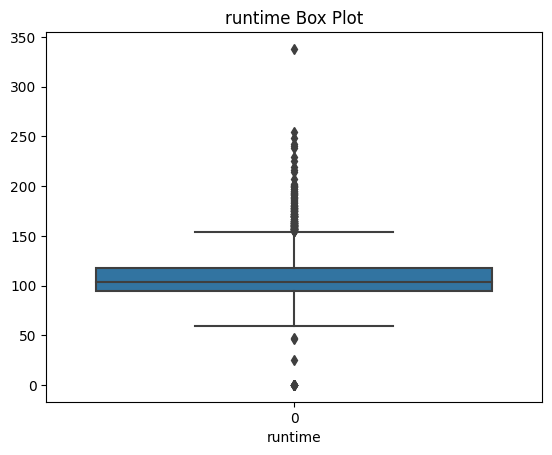

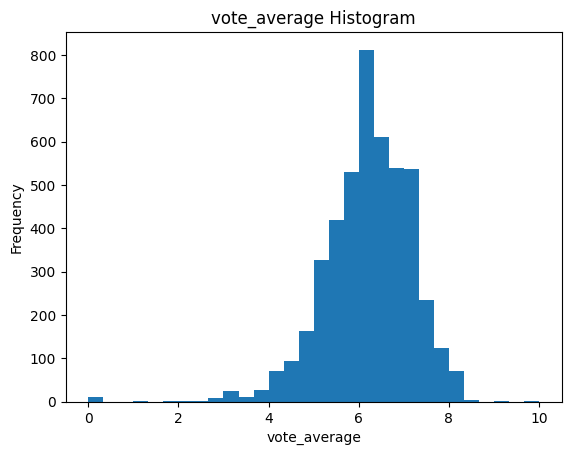

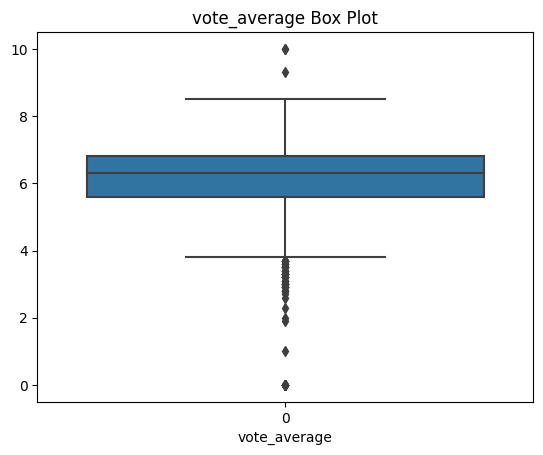

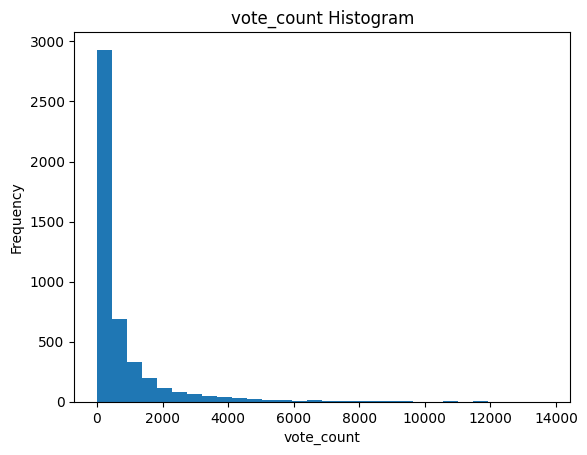

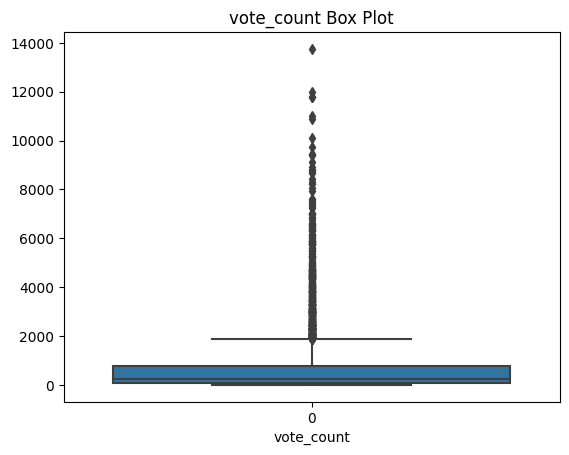

In [9]:
### First, we plot the data to determine the best method to deal with each variable

# Helper function for plotting histograms
def plot_histogram(data, title, xlabel, ylabel):
    plt.figure()
    plt.hist(data, bins=30)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Helper function for plotting box plots
def plot_boxplot(data, title, xlabel):
    plt.figure()
    sns.boxplot(data=data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

# Plot histograms and box plots for each numerical variable
variables = ['budget', 'popularity', 'release_date', 'revenue', 'runtime', 'vote_average', 'vote_count']

for var in variables:
    if var == 'release_date':
        # Extract the year and plot histograms and box plots
        years = pd.to_datetime(content_based_df['release_date']).dt.year
        plot_histogram(years, f'{var} Histogram', var, 'Frequency')
        plot_boxplot(years, f'{var} Box Plot', var)
    else:
        plot_histogram(content_based_df[var], f'{var} Histogram', var, 'Frequency')
        plot_boxplot(content_based_df[var], f'{var} Box Plot', var)

#### Plots analysis and method choice explanation
Budget: Since it's extremely right-skewed with outliers on the higher extreme, we can apply a log transformation to reduce the skewness and scale down the large values.

Popularity: As it's also extremely right-skewed with outliers on the higher extreme, we can again apply a log transformation for the same reasons as for the budget.

Release_date: Since it's left-skewed with outliers on the lower end, we could try applying a power transformation (e.g., square or cube) to reduce the skewness. Alternatively, we could also try binning the years into decades to create categorical features. We will try both and compare the tranformations to determine which is best.

Revenue: Same as budget, apply a log transformation to reduce the skewness and scale down the large values.

Runtime: As it's more centered with many outliers, we can try applying a standard scaling (subtract mean and divide by standard deviation) to normalize the data.

Vote_average: Since it's slightly left-skewed with many outliers on the lower end and few outliers on the higher end, we could apply a power transformation (e.g., square) to reduce the skewness.

Vote_count: As it's extremely right-skewed with many outliers on the higher end, we can apply a log transformation to reduce the skewness and scale down the large values.

In [10]:
# Create a new DataFrame with the transformed numerical features
numerical_transformed = content_based_df[['budget', 'popularity', 'release_date', 'revenue', 'runtime', 'vote_average', 'vote_count']].copy()

# Apply log transformation to budget, popularity, revenue, and vote_count
numerical_transformed['budget'] = np.log1p(numerical_transformed['budget'])
numerical_transformed['popularity'] = np.log1p(numerical_transformed['popularity'])
numerical_transformed['revenue'] = np.log1p(numerical_transformed['revenue'])
numerical_transformed['vote_count'] = np.log1p(numerical_transformed['vote_count'])

# Apply power transformation to release_date and vote_average
numerical_transformed['release_date'] = numerical_transformed['release_date'].dt.year
numerical_transformed['release_date'] = numerical_transformed['release_date'] ** 2
numerical_transformed['vote_average'] = numerical_transformed['vote_average'] ** 2

# Apply standard scaling to runtime
scaler = StandardScaler()
numerical_transformed['runtime'] = scaler.fit_transform(numerical_transformed[['runtime']])

      budget  popularity  release_date    revenue   runtime  vote_average  \
0  19.283571    5.020174       4036081  21.748578  2.569721         51.84   
1  19.519293    4.942232       4028049  20.683485  2.901938         47.61   
2  19.316769    4.685614       4060225  20.596199  1.905287         39.69   
3  19.336971    4.730153       4048144  20.804790  2.712100         57.76   
4  19.376192    3.805039       4048144  19.464974  1.145935         37.21   

   vote_count  
0    9.375940  
1    8.412055  
2    8.404472  
3    9.116799  
4    7.661527  


In [ ]:
print(numerical_transformed.head())

### Text Feature Engineering
***Variables Handled:***
- keywords
- cast
- crew

In [13]:
### Create a combined text feature for cast, crew, and keywords
### Create transformed_df contaning all tansformed data
     # Creating column text_features (which we will apply tranformation function to later)

def create_combined_feature(row):
    return ' '.join(row['keywords']) + ' ' + ' '.join(row['cast'][:3]) + ' ' + ' '.join(row['crew'][:3])

# Combine the one_hot_encoded and numerical_transformed DataFrames
tranformed_df = pd.concat([one_hot_encoded, numerical_transformed], axis=1)
tranformed_df['text_features'] = content_based_df.apply(create_combined_feature, axis=1)

In [16]:
### Apply TF-IDF vectorization to the text_features column
     # This converts text-based feature to numerical format
    
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(tranformed_df['text_features'])

In [47]:
### Similarity functions

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Combine the transformed numerical and one-hot encoded features with the TF-IDF matrix
all_transformed_features = pd.concat([tranformed_df.drop('text_features', axis=1), tfidf_df], axis=1)

# Calculate cosine similarity between movies
cosine_sim = cosine_similarity(all_transformed_features, all_transformed_features)

# Function for getting the recommendations given a specific movie and a specific similarity function
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = content_based_df[content_based_df['title_movies'] == title].index[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    print(sim_scores[:10])
    print(sim_scores[-10:])

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    
    # Normalize the similarity scores to be between 0 and 1
    max_score = sim_scores[0][1]
    sim_scores = [(i[0], i[1] / max_score) for i in sim_scores]


    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Get the top 10 most similar movies with their titles, similarity scores, and ratings
    recommendations = content_based_df[['title_movies', 'vote_average']].iloc[movie_indices]
    recommendations['similarity_score'] = [round(i[1], 4) for i in sim_scores]  # Round to 4 decimal places


    # Reset the index and drop the original index
    recommendations = recommendations.reset_index(drop=True)
    recommendations.index += 1
    
    return recommendations

In [48]:
print(get_recommendations('The Truman Show'))

[(0, 0.9999999999963453), (1, 0.9999999999935341), (2, 0.9999999999845487), (3, 0.9999999999989735), (4, 0.9999999999813913), (5, 0.9999999999777883), (6, 0.9999999999983271), (7, 0.9999999999973567), (8, 0.9999999999980912), (9, 0.9999999999733152)]
[(4622, 0.9999999999682908), (4623, 0.9999999999669898), (4624, 0.9999999999934908), (4625, 0.9999999999565214), (4626, 0.9999999999899564), (4627, 0.9999999999885045), (4628, 0.9999999999615881), (4629, 0.9999999999713339), (4630, 0.9999999999502189), (4631, 0.9999999999622687)]
                             title_movies  vote_average  similarity_score
1                                  WALL·E           7.8               1.0
2                              Big Hero 6           7.8               1.0
3                             Gran Torino           7.8               1.0
4                               Toy Story           7.7               1.0
5                 Raiders of the Lost Ark           7.7               1.0
6   Eternal Sunshine of 

In [51]:
print(get_recommendations('Batman Begins'))

[(0, 0.999999999998876), (1, 0.9999999999972274), (2, 0.9999999999908343), (3, 0.9999999999996021), (4, 0.9999999999880741), (5, 0.999999999985336), (6, 0.9999999999994301), (7, 0.9999999999992764), (8, 0.9999999999996197), (9, 0.9999999999816923)]
[(4622, 0.9999999999710718), (4623, 0.9999999999700174), (4624, 0.9999999999937315), (4625, 0.9999999999617031), (4626, 0.9999999999923868), (4627, 0.9999999999923295), (4628, 0.9999999999678398), (4629, 0.9999999999728715), (4630, 0.9999999999567712), (4631, 0.9999999999664506)]
                                         title_movies  vote_average  \
1                          X-Men: Days of Future Past           7.5   
2            Harry Potter and the Philosopher's Stone           7.5   
3                 Harry Potter and the Goblet of Fire           7.5   
4   Pirates of the Caribbean: The Curse of the Bla...           7.5   
5                                         The Martian           7.6   
6                 Captain America: The Winte

In [50]:
content_based_df[content_based_df["original_title"].str.contains("Batman")]

,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title_movies,vote_average,vote_count,cast,crew,keywords
9,250000000,"[Action, Adventure, Fantasy]",209112,en,Batman v Superman: Dawn of Justice,155.790452,"[DC Comics, Atlas Entertainment, Warner Bros.,...",[United States of America],2016-03-23,873260194,151.0,[English],Batman v Superman: Dawn of Justice,5.7,7004,"[Ben Affleck, Henry Cavill, Gal Gadot, Amy Ada...","[Hans Zimmer, Charles Roven, Christopher Nolan...","[dc comics, vigilante, superhero, based on com..."
119,150000000,"[Action, Crime, Drama]",272,en,Batman Begins,115.040024,"[DC Comics, Legendary Pictures, Warner Bros., ...","[United Kingdom, United States of America]",2005-06-10,374218673,140.0,"[English, اردو, 普通话]",Batman Begins,7.5,7359,"[Christian Bale, Michael Caine, Liam Neeson, K...","[Lucinda Syson, Larry J. Franco, Hans Zimmer, ...","[himalaya, martial arts, dc comics, crime figh..."
211,125000000,"[Action, Crime, Fantasy]",415,en,Batman & Robin,50.073575,"[PolyGram Filmed Entertainment, Warner Bros.]","[United Kingdom, United States of America]",1997-06-20,238207122,125.0,[English],Batman & Robin,4.2,1418,"[George Clooney, Chris O'Donnell, Arnold Schwa...","[Lance Brown, Mali Finn, Bob Kane, Andrew Adam...","[double life, dc comics, dual identity, crime ..."
300,100000000,"[Action, Crime, Fantasy]",414,en,Batman Forever,48.205606,"[Warner Bros., Polygram Filmed Entertainment]","[United Kingdom, United States of America]",1995-05-31,336529144,121.0,[English],Batman Forever,5.2,1498,"[Val Kilmer, Tommy Lee Jones, Jim Carrey, Nico...","[Tim Burton, Mali Finn, Bob Kane, Joel Schumac...","[riddle, dc comics, rose, gotham city, partner..."
429,80000000,"[Action, Fantasy]",364,en,Batman Returns,59.113174,"[PolyGram Filmed Entertainment, Warner Bros.]","[United Kingdom, United States of America]",1992-06-19,280000000,126.0,[English],Batman Returns,6.6,1673,"[Michael Keaton, Danny DeVito, Michelle Pfeiff...","[Tim Burton, Tim Burton, Danny Elfman, Chris L...","[holiday, corruption, double life, dc comics, ..."
1358,35000000,"[Fantasy, Action]",268,en,Batman,44.104469,"[PolyGram Filmed Entertainment, The Guber-Pete...","[United Kingdom, United States of America]",1989-06-23,411348924,126.0,"[English, Français]",Batman,7.0,2096,"[Jack Nicholson, Michael Keaton, Kim Basinger,...","[Ray Lovejoy, Roger Pratt, Tim Burton, Danny E...","[double life, dc comics, dual identity, chemic..."
3825,3500000,"[Action, Animation]",142061,en,"Batman: The Dark Knight Returns, Part 2",25.891466,"[DC Comics, Warner Bros. Animation, Warner Pre...",[United States of America],2013-01-18,0,78.0,[English],"Batman: The Dark Knight Returns, Part 2",7.9,419,"[Peter Weller, Ariel Winter, David Selby, Mich...","[Frank Miller, Frank Miller, Michael Uslan, Ja...","[dc comics, future, joker, robin, based on gra..."
4207,1377800,"[Family, Adventure, Comedy, Science Fiction, C...",2661,en,Batman,9.815394,"[Twentieth Century Fox Film Corporation, DC Co...",[United States of America],1966-07-30,0,105.0,[English],Batman,6.1,203,"[Adam West, Burt Ward, Lee Meriwether, Cesar R...","[Bob Kane, Nelson Riddle, William Dozier, Lesl...","[submarine, dc comics, missile, shark attack, ..."
